### Libraries

In [3]:
# !pip install torch torchvision
# !pip install transformers datasets
# !pip install transformers[torch]

In [4]:
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
from PIL import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\Alexandra\Desktop\Backup of user data\ITU\year 2\AMLCV\AMLCV\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the Data

In [5]:
trainds, testds = load_dataset("cifar10", split=["train[:5000]","test[:1000]"])
splits = trainds.train_test_split(test_size=0.1)
trainds = splits['train']
valds = splits['test']
trainds, valds, testds

(Dataset({
     features: ['img', 'label'],
     num_rows: 4500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 1000
 }))

In [6]:
trainds.features, trainds.num_rows, trainds[0]

({'img': Image(mode=None, decode=True),
  'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])},
 4500,
 {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  'label': 8})

In [7]:
itos = dict((k,v) for k,v in enumerate(trainds.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(trainds.features['label'].names))
itos, stoi

({0: 'airplane',
  1: 'automobile',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck'},
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

ship


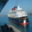

In [8]:
img, lab = trainds[0]['img'], itos[trainds[0]['label']]
print(lab)
img

In [9]:
print(img.size)

(32, 32)


### Preprocessing Data

In [10]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

mu, sigma = processor.image_mean, processor.image_std
size = processor.size
size

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e61e286e-1591-4ab2-a93e-34fec62b3b25)')' thrown while requesting HEAD https://huggingface.co/google/vit-base-patch16-224/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].


{'height': 224, 'width': 224}

In [11]:
norm = Normalize(mean=mu, std=sigma)

_transf = Compose([
    Resize(size['height']),
    ToTensor(),
    norm
])

def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

In [12]:
trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

In [13]:
trainds[0].keys()

dict_keys(['img', 'label', 'pixels'])

torch.Size([3, 224, 224])
tensor(-0.9843) tensor(0.8902)
tensor(0.0078) tensor(0.9451)


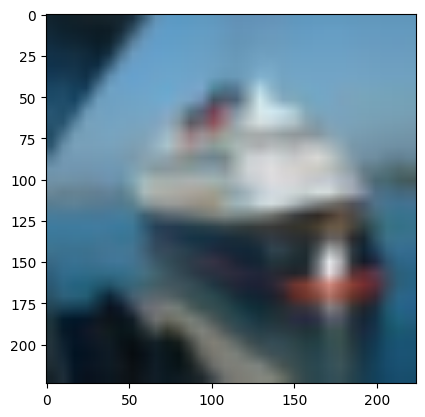

In [14]:
ex = trainds[0]['pixels']
print(ex.shape)
print(torch.min(ex), torch.max(ex))
ex = (ex+1)/2
print(torch.min(ex), torch.max(ex))

exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

### Model - Fine Tuning

In [15]:
model = ViTForImageClassification.from_pretrained(model_name)
print(model.classifier) #The google/vit-base-patch16-224 model is originally fine tuned on imagenet-1K with 1000 output classes

# print(model.config)
#To use Cifar-10, it needs to be fine tuned again with 10 output classes
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10,  ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

Linear(in_features=768, out_features=1000, bias=True)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


### Hugging Face Trainer

In [16]:
!pip show accelerate

Name: accelerate
Version: 1.0.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: C:\Users\Alexandra\Desktop\Backup of user data\ITU\year 2\AMLCV\AMLCV\.venv\Lib\site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [17]:
args = TrainingArguments(
    f"test-cifar-10",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

trainer = Trainer(
    model,
    args, 
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_2768\4006996412.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training the model for fine tuning

In [16]:
ls%load_ext tensorboard
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 32972), started 0:06:54 ago. (Use '!kill 32972' to kill it.)

In [17]:

                                                                                                        trainer.train()

C:\Users\Alexandra\Desktop\Backup of user data\ITU\year 2\AMLCV\AMLCV\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss



KeyboardInterrupt


KeyboardInterrupt



### Evaluation

In [23]:
outputs = trainer.predict(testds)
print(outputs.metrics)

{'test_loss': 0.07223748415708542, 'test_accuracy': 0.973, 'test_runtime': 28.5169, 'test_samples_per_second': 35.067, 'test_steps_per_second': 4.383}


In [30]:
itos[np.argmax(outputs.predictions[0])], itos[outputs.label_ids[0]]

('cat', 'cat')

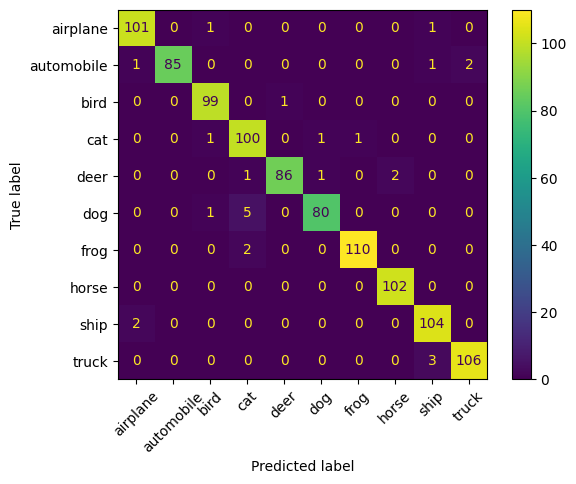

In [31]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = trainds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)